In [2]:
%load_ext autoreload
%autoreload 2

import asyncio
import json
import random
import time
import base64
from pathlib import Path

from playwright.async_api import async_playwright


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Start Playwright (headed) and open a page.
# After this runs, use the opened browser window to log in manually.
# Navigate to https://polymer.nims.go.jp
pw = await async_playwright().start()
browser = await pw.chromium.launch(headless=False)
context = await browser.new_context()
page = await context.new_page()


In [3]:
# Quick status check: view cookies + storage state snapshot.
cookies = await context.cookies()
print(f'cookies: {len(cookies)}')
storage_state = await context.storage_state()
print('storage state keys:', list(storage_state.keys()))


cookies: 13
storage state keys: ['cookies', 'origins']


In [7]:
# Replay a single API request using the authenticated browser context.
api_url = 'https://polymer.nims.go.jp/PoLyInfo/api/6627766'
# pid_uuid = '945f6b5d-04ee-5df1-803d-b985036b80ba'
pid_uuid = 'b0acfef5-9eb4-50ea-9188-291a6087a612'
captcha_id = None  # set to a string if the site requires it

headers = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Content-Type': 'application/json; charset=UTF-8',
    'Origin': 'https://polymer.nims.go.jp',
    'Referer': 'https://polymer.nims.go.jp/PoLyInfo/polymer-information',
    'X-Requested-With': 'XMLHttpRequest',
}
if captcha_id:
    headers['captchaId'] = captcha_id

payload = json.dumps({'pid_uuid': pid_uuid})

resp = await context.request.post(api_url, headers=headers, data=payload)
print('status:', resp.status)
print('content-type:', resp.headers.get('content-type'))


status: 200
content-type: application/json;charset=UTF-8


In [8]:
data_json = await resp.json()
print('json type:', type(data_json))

data_json  # show parsed JSON in notebook output

json type: <class 'dict'>


{'result': True,
 'json': 'eyJwb2x5bWVyX25hbWUiOiJwb2x5KHByb3AtMS1lbmUpIiwiY3VfY2hlbWljYWxfc3RydWN0dXJlIjpbImRhdGE6aW1hZ2UvcG5nO2Jhc2U2NCxpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBR0lBQUFBOENBWUFBQUNkSVcrSkFBQUtqMGxFUVZSNEFlM0JNV2djUjZQQThmODJxVTZwcFNhVnp3T3BOR2I1cXNNblVzbGhTYVZ3Q3k3ayt3NVNCQXViVkQ1TFpEekJXQzRkUzZRSW5KRUNoaEZXNlNCVkQ2OFJYL0VJMmFzQ2sxRzdqQ3MzVXBWbTN5NDg4UmJ6dllsWCtjQldmTDlmVkZhWWVlZWlzc0xNT3hlVkZXYmV1YWlzRUxDNXVjbmR1M2M1OCtMRkMvcjlQalAvcDkvdjgvTGxTMnFYTDEvR1drdGJVVmtoUUd0TlRTbkZUSmozbmppT0tZcUN0cUt5UW9EV21wcFNpcGt3NXh4SmttQ3RwYTJvckJDZ3RhYW1sR0ltekh0UEhNY1VSVUZiVVZraFFHdE5UU25GVEpoemppUkpzTmJTVmxSV0NOQmFVMU5LTVJQbXZTZU9ZNHFpb0syb3JCQ2d0YWFtbEdJbXpEbEhraVJZYTJrcktpc0VhSzJwS2FXWUNmUGVFOGN4UlZIUVZsUldDTkJhVTFOS01SUG1uQ05KRXF5MXRCV1ZGUUswMXRTVVVzeUVlZStKNDVpaUtHZ3JLaXNFYUsycEthV1lDWFBPa1NRSjFscmFpc29LQVZwcmFrb3Bac0s4OThSeFRGRVV0QldWRlFLMDF0U1VVc3lFT2VkSWtnUnJMVzFGWllVQXJUVTFwUlF6WWQ1NzRqaW1LQXJhaXNvS0FWcHJha29wWnNLY2N5UkpncldXdHFLeVFvRFdtcHBTaXBrdzd6MXhIRk1VQlcxRlpZVUFyVFUxcFJRelljN

{'polymer_name': 'poly(prop-1-ene)',
 'cu_chemical_structure': [''],
 'polymer_id': 'P010002',
 'polymer_uuid': 'b0acfef5-9eb4-50ea-9188-291a6087a612',
 'iupac_structure_based_name': ['poly(1-methylethylene)'],
 'iupac_source_based_name': ['poly(prop-1-ene)'],
 'other_name': ['polypropylene', 'polypropene', 'poly(propylene)'],
 'abbreviation': ['PP'],
 'polymer_class': ['Polyolefins'],
 'cu_formula': 'C3H6',
 'formula_weight': 42.08,
 'smiles': '*CC(C)*',
 'copolymers_including_this_components': {'copolymers_including_this_component_cuid': 'CU010002',
  'copolymers_including_this_component': 133},
 'polymer_blends_including_this_component': 202,
 'polymer_nmr_ir_link': True}
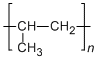

In [9]:
json.loads(base64.b64decode(data_json['json']).decode("utf-8"))

In [8]:
# Batch fetch with defensive checks, jittered pacing, and persistent saving.
import pickle

pid_path = Path('../data/pid_uuids.txt')
out_path = Path('../data/polymer_details.pkl')

pids = [p.strip() for p in pid_path.read_text().splitlines() if p.strip()]

if out_path.exists():
    with out_path.open('rb') as f:
        results = pickle.load(f)
    if not isinstance(results, dict):
        raise ValueError('polymer_details.pkl is not a dict; move it aside and retry')
else:
    results = {}

def save_results(d):
    tmp_path = out_path.with_suffix(out_path.suffix + '.tmp')
    with tmp_path.open('wb') as f:
        pickle.dump(d, f)
    tmp_path.replace(out_path)

api_url = 'https://polymer.nims.go.jp/PoLyInfo/api/6627766'
captcha_id = None  # set to a string if the site requires it

headers = {
    'Accept': 'application/json, text/javascript, */*; q=0.01',
    'Content-Type': 'application/json; charset=UTF-8',
    'Origin': 'https://polymer.nims.go.jp',
    'Referer': 'https://polymer.nims.go.jp/PoLyInfo/polymer-information',
    'X-Requested-With': 'XMLHttpRequest',
}
if captcha_id:
    headers['captchaId'] = captcha_id

async def fetch_one(pid_uuid):
    payload = json.dumps({'pid_uuid': pid_uuid})
    resp = await context.request.post(api_url, headers=headers, data=payload)
    status = resp.status
    ctype = (resp.headers.get('content-type') or '').lower()

    if status != 200:
        text = await resp.text()
        return {
            'ok': False,
            'status': status,
            'content_type': ctype,
            'text_snippet': text[:500],
        }

    if 'application/json' not in ctype:
        text = await resp.text()
        return {
            'ok': False,
            'status': status,
            'content_type': ctype,
            'text_snippet': text[:500],
        }

    try:
        data_json = await resp.json()
        return {'ok': True, 'data': data_json}
    except Exception as e:
        text = await resp.text()
        return {
            'ok': False,
            'status': status,
            'content_type': ctype,
            'error': str(e),
            'text_snippet': text[:500],
        }

total = len(pids)
print(f'total pids: {total}, already have: {len(results)}')

for idx, pid_uuid in enumerate(pids, start=1):
    if pid_uuid in results:
        continue

    res = await fetch_one(pid_uuid)

    if res.get('ok'):
        results[pid_uuid] = res['data']
        print(f'[OK] {idx}/{total} {pid_uuid}')
    else:
        print(f"[FAIL] {idx}/{total} {pid_uuid} status={res.get('status')} content-type={res.get('content_type')}")
        print(res.get('text_snippet', '')[:300])
        save_results(results)
        action = input('Failure detected. Enter to continue, or type stop to halt: ').strip().lower()
        if action in {'stop', 'q', 'quit'}:
            break

    save_results(results)

    # jittered pacing to reduce scraping signals
    await asyncio.sleep(random.uniform(5.0, 20.0))
    if idx % 25 == 0:
        await asyncio.sleep(random.uniform(15.0, 30.0))


total pids: 1267, already have: 1266
[OK] 435/1267 84fa68f9-153a-5aab-ba8e-479fb1b651fd
